# Learned System Dynamics Model

The goal of the following experiements is to explore the feasibility of automatically discovering the underlying dynamics of a closed loop linear system by learning a mapping between controls applied to the system and the resulting changes in system state.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

The first system under question will be a particle in a vaccum undergoing random (but known) accelerations via a control signal. The goal will be to recover the state-transition-matrix of the underlying ground truth dynamics by collecting operating data and optimizing parameters of a model to minimize the error between observed states, and network predicted states. For this scenario, the state of the system will be

In [2]:
def make_state(pos, vel):
    return np.concatenate([np.array(pos), np.array(vel)])

make_state([1, 2, 3], [4, 5, 6])

array([1, 2, 3, 4, 5, 6])

The ground truth STM that we are looking to recover will be

In [3]:
dt = 0.1
stm_gt = np.array([
    [1, 0, 0,dt, 0, 0, 0, 0, 0], # pos.x
    [0, 1, 0, 0,dt, 0, 0, 0, 0], # pos.y
    [0, 0, 1, 0, 0,dt, 0, 0, 0], # pos.z
    [0, 0, 0, 1, 0, 0,dt, 0, 0], # vel.x
    [0, 0, 0, 0, 1, 0, 0,dt, 0], # vel.y
    [0, 0, 0, 0, 0, 1, 0, 0,dt], # vel.z
    [0, 0, 0, 0, 0, 0, 1, 0, 0], # acc.x
    [0, 0, 0, 0, 0, 0, 0, 1, 0], # acc.y
    [0, 0, 0, 0, 0, 0, 0, 0, 1], # acc.z
])

First we will generate some samples randomly. Where even samples are an initial random state, and odd samples are the propogation of that sample via the stm we are hoping to learn.

In [7]:

X = np.zeros((10000, 9), dtype=np.dtype("float32"))
# U = np.zeros((10000, 3), dtype=np.dtype("float32"))

sub_steps = 2
for i in range(0, X.shape[0] - sub_steps, sub_steps):
    X[i] = np.random.normal(scale=10, size=9)
#     U[i] = np.random.normal(scale=0.1, size=3)

    X[i+1] = stm_gt @ X[i]
    X[i+1,0:3] += np.random.normal(scale=0.1, size=3)
    X[i+1,3:6] += np.random.normal(scale=0.01, size=3)
#     X[i+1] = stm_gt @ X[i+1]
    
# XU = np.concatenate([X, U], axis=1)
XU = X

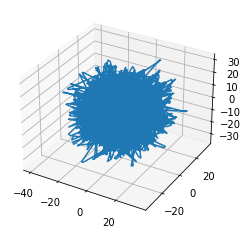

In [8]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])
plt.show()

In [76]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stm_stack = nn.Sequential(
            nn.Linear(9, 9, dtype=torch.float32, bias=False),
#             nn.Linear(9, 9, dtype=torch.float32, bias=False),
        )

    def forward(self, x):
        x = self.flatten(x)
        outputs = self.stm_stack(x)
        return outputs

model = NeuralNetwork().to(device)

def train_loop(model, loss_fn, optimizer, batch_sampler=None, X_t=XU, epochs=50000, batch_size=1000):
    losses = np.zeros(epochs)
    
    if batch_sampler is None:
        def default_sampler(X):
            sample_indices = list(range(0, XU.shape[0] - 1, 2))
            batch_inds = np.random.choice(sample_indices, size=batch_size)
            return torch.from_numpy(X_t[batch_inds]), torch.from_numpy(X_t[batch_inds+1])
        
        batch_sampler = default_sampler
        
    for epoch in range(epochs):
        X, Y = batch_sampler(X_t)
        
        if device == 'cuda':
            h = model(X.cuda())
            loss = loss_fn(h, Y.cuda())
        else:
            h = model(X)
            loss = loss_fn(h, Y)
            
        losses[epoch] = loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if epoch % 1000 == 0:
            loss, current = loss.item(), epoch * len(X)
            print(f"loss: {loss:>7f}  [{epoch:>5d}/{epochs:>5d}]")

    ax = plt.figure().add_subplot()
    ax.plot(losses, label='Loss')
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.show()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()

Using cpu device


loss: 10.103897  [    0/50000]
loss: 9.190125  [ 1000/50000]
loss: 8.627508  [ 2000/50000]
loss: 7.840941  [ 3000/50000]
loss: 7.101610  [ 4000/50000]
loss: 6.409816  [ 5000/50000]
loss: 5.723835  [ 6000/50000]
loss: 5.035758  [ 7000/50000]
loss: 4.264124  [ 8000/50000]
loss: 3.604745  [ 9000/50000]
loss: 2.863191  [10000/50000]
loss: 2.147876  [11000/50000]
loss: 1.514508  [12000/50000]
loss: 0.977139  [13000/50000]
loss: 0.593997  [14000/50000]
loss: 0.222883  [15000/50000]
loss: 0.029168  [16000/50000]
loss: 0.029739  [17000/50000]
loss: 0.029083  [18000/50000]
loss: 0.029495  [19000/50000]
loss: 0.029695  [20000/50000]
loss: 0.029466  [21000/50000]
loss: 0.028929  [22000/50000]
loss: 0.029396  [23000/50000]
loss: 0.029674  [24000/50000]
loss: 0.029153  [25000/50000]
loss: 0.029123  [26000/50000]
loss: 0.029032  [27000/50000]
loss: 0.029430  [28000/50000]
loss: 0.028960  [29000/50000]
loss: 0.030286  [30000/50000]
loss: 0.029238  [31000/50000]
loss: 0.029634  [32000/50000]
loss: 0.0

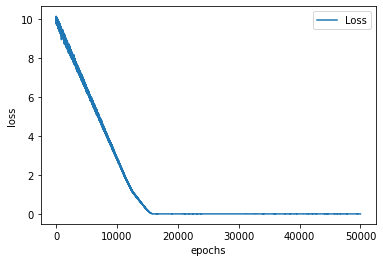

In [77]:
train_loop(model, loss_fn, optimizer)

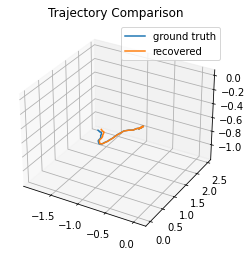

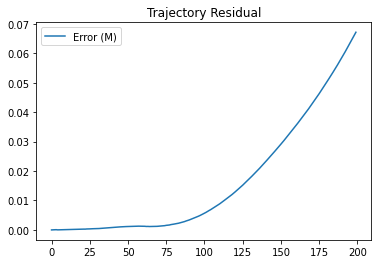

In [75]:
def plot_eval(steps=200):
    X_gt = np.zeros((steps, 9), dtype=np.dtype("float32"))
    H = np.zeros((steps, 9), dtype=np.dtype("float32"))
    error = np.zeros(steps)

    # evaluate with one trajectory using the ground truth and another using the learned model
    for i in range(0, H.shape[0] - 1):
        u_i = np.random.normal(scale=0.1, size=3)
        X_gt[i+1] = stm_gt @ np.concatenate([X_gt[i,0:6], u_i])

        X_np = torch.from_numpy(np.concatenate([H[i,0:6], u_i]).reshape((1, 9)).astype(np.dtype("float32")))

        if device == 'cuda':
            H[i+1] = model.forward(X_np.cuda()).detach().cpu().numpy()
        else:
            H[i+1] = model.forward(X_np).detach().cpu().numpy()

        res_i = X_gt[i+1] - H[i+1]
        error[i+1] = np.sqrt(np.dot(res_i, res_i))

    ax = plt.figure().add_subplot(projection='3d')
    ax.set_title("Trajectory Comparison")
    ax.plot(X_gt[:,0], X_gt[:,1], X_gt[:,2], label="ground truth")
    ax.plot(H[:,0], H[:,1], H[:,2], label="recovered")
    ax.legend()
    plt.show()

    ax = plt.figure().add_subplot()
    ax.set_title("Trajectory Residual")
    ax.plot(error, label="Error (M)")
    ax.legend()
    plt.show()
plot_eval()

Upon visual examination of the two trajectories, the model appears to learn the dynamics very well, with an error of 3cm after 20 seconds of propagation without any corrective feedback. However the pairs it is trained on are not realistic operating data, which we will explore next.

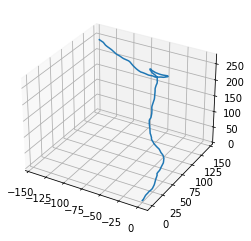

[ 0.          0.          0.          0.          0.          0.
  0.01502036 -0.01423208 -0.06913681]


In [70]:
X_op = np.zeros((10000, 9), dtype=np.dtype("float32"))
# U = np.zeros((10000, 3), dtype=np.dtype("float32"))

sub_steps = 1
for i in range(0, X_op.shape[0] - sub_steps, sub_steps):
    u_i = np.random.normal(scale=0.1, size=3)

    X_op[i,6:] = u_i
    X_op[i+1] = stm_gt @ X_op[i]
    # add process/measurement noise
#     X_op[i+1,0:3] += np.random.normal(scale=0.1, size=3)
#     X_op[i+1,3:6] += np.random.normal(scale=0.01, size=3)
#     X[i+1] = stm_gt @ X[i+1]

X_ts = np.zeros((10000, 9), dtype=np.dtype("float32"))
for i in range(9):
    X_ts[i*1000:(i+1)*1000] = X_op[0:1000]
    X_ts[i*1000:(i+1)*1000,0:3] += np.random.normal(scale=30, size=3)
    
ax = plt.figure().add_subplot(projection='3d')
ax.plot(X_op[:,0], X_op[:,1], X_op[:,2])
plt.show()
print(X_op[0])

loss: 11.086462  [    0/60000]
loss: 5.772489  [ 1000/60000]
loss: 2.812292  [ 2000/60000]
loss: 1.153064  [ 3000/60000]
loss: 0.337995  [ 4000/60000]
loss: 0.074341  [ 5000/60000]
loss: 0.074059  [ 6000/60000]
loss: 0.072804  [ 7000/60000]
loss: 0.073789  [ 8000/60000]
loss: 0.072212  [ 9000/60000]
loss: 0.072380  [10000/60000]
loss: 0.071499  [11000/60000]
loss: 0.072571  [12000/60000]
loss: 0.069701  [13000/60000]
loss: 0.072203  [14000/60000]
loss: 0.072891  [15000/60000]
loss: 0.071415  [16000/60000]
loss: 0.071143  [17000/60000]
loss: 0.070119  [18000/60000]
loss: 0.070216  [19000/60000]
loss: 0.069789  [20000/60000]
loss: 0.070786  [21000/60000]
loss: 0.070026  [22000/60000]
loss: 0.069357  [23000/60000]
loss: 0.070535  [24000/60000]
loss: 0.069412  [25000/60000]
loss: 0.069053  [26000/60000]
loss: 0.068667  [27000/60000]
loss: 0.068475  [28000/60000]
loss: 0.067716  [29000/60000]
loss: 0.065849  [30000/60000]
loss: 0.067902  [31000/60000]
loss: 0.068164  [32000/60000]
loss: 0.0

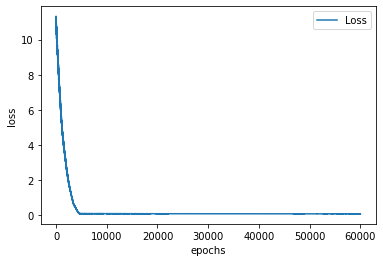

In [71]:
train_loop(model, loss_fn, optimizer, X_t=X_ts, batch_size=2000, epochs=60000)

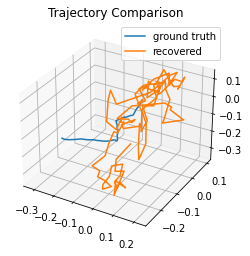

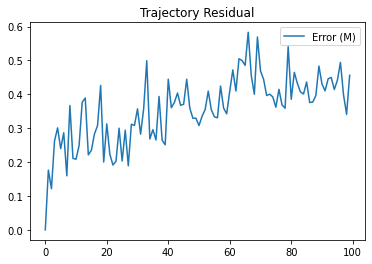

In [73]:
plot_eval(steps=100)